In [1]:
from IPython.display import display, HTML
import scipy.constants as sc
from scipy.optimize import fsolve
from ipywidgets import interact, widgets
%matplotlib notebook

import numpy as np
import cmath
import matplotlib.pyplot as plt
import scipy.constants as sc
plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': r"\usepackage{amsmath} \boldmath"
})
import os
import h5py

print(os.getpid())
%cd ../../

4957
/media/work/docs/codes/QuCF/scripts-py


In [2]:
import pylib.mix as mix
from matplotlib import ticker
import time

path_ = "../results/KIN1D1D-results/"
colors_     = ['b', 'r',  'g', 'gray', 'orange']
line_styles = ['-', '--', '--',    '-',     '-']

# cmap = 'seismic'
# cmap = 'bwr'
# cmap = 'jet'
# cmap = 'coolwarm'
cmap_one_sign_ = 'YlGn'
cmap_two_signs_= 'coolwarm'
def fmt_(x, pos):
    a, b = '{:.3e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

In [12]:
# ---------------------------------------------------
# --- For reading results ---
# ---------------------------------------------------
def read_results(path, fname_loc):
    dd = {}
    fname = path + "/" + fname_loc
    dd["fname"] = fname
    
    print(f"Reading the file {fname}...")
    with h5py.File(fname, "r") as f:
        # ---
        bg           = f["basic"]
        date_sim    = bg["date-of-simulation"][()].decode("utf-8")
        # ---
        bg = f["parameters"]
        w = bg["w"][()]
        xs  = bg["source_x0"][()]
        dxs = bg["source_dx"][()] 
        # ---
        bg = f["grids"]
        x = np.array(bg["x"])
        v = np.array(bg["v"])
        Nx = len(x)
        Nv = len(v)
        # ---
        bg = f["result"]
        psi = np.array(bg["psi"])

    print("date of the simulation: ", date_sim)
        
    print("Nx, Nv: {:d}, {:d}".format(Nx,Nv))

    N_var = Nx*Nv
    dd["g"] = np.zeros((Nx,Nv), dtype=complex)
    dd["E"] = np.zeros(Nx, dtype=complex)
    for ix in range(Nx):
        vE = psi[ix*Nv + N_var]
        dd["E"][ix] = complex(vE[0], vE[1])
        for iv in range(Nv):
            vg = psi[ix*Nv+iv]
            dd["g"][ix,iv] = complex(vg[0], vg[1])
            
    dd.update({
        "x": x, "v": v,
        "x0": xs, "ds": dxs,
        "Nx": Nx, "Nv": Nv,
        "nx": int(np.log2(Nx)), "nv": int(np.log2(Nv)),
        "w": w, 
        "source-x0": xs, "source-dx": dxs
    })
    return dd


# -----------------------------------------------------------------
# --- For plotting ---
# -----------------------------------------------------------------
def plot_results_one(dd):
    fig_gxv_re, fig_gxv_im = None, None
    
    # --- distribution function ---
    XX, YY = np.meshgrid(dd["v"], dd["x"]-dd["x0"])
    
    dv = np.diff(dd["v"])[0]
    
    fig_gxv_re = plt.figure()
    ax = fig_gxv_re.add_subplot(111)
    cs = ax.contourf(XX, YY, np.real(dd["g"]/dv), levels=100, cmap=cmap_two_signs_)
    fig_gxv_re.colorbar(cs, ax = ax, format=ticker.FuncFormatter(fmt_))
    ax.set_xlabel('$v$')
    ax.set_ylabel('$x-x_0$')
    ax.set_title('Re[g]')
    
#     fig_gxv_im = plt.figure()
#     ax = fig_gxv_im.add_subplot(111)
#     cs = ax.contourf(XX, YY, np.imag(dd["g"]/dv), levels=100, cmap=cmap_two_signs_)
#     fig_gxv_im.colorbar(cs, ax = ax, format=ticker.FuncFormatter(fmt_))
#     ax.set_xlabel('$v$')
#     ax.set_ylabel('$x-x_0$')
#     ax.set_title('Im[g]')
    
    
#     # --- electric field ---
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(dd["x"] - dd["x0"], np.real(dd["E"]), color='b', linewidth = 2, linestyle='-', label="Re[E]")
#     ax.plot(dd["x"] - dd["x0"], np.imag(dd["E"]), color='r', linewidth = 2, linestyle='--', label="Im[E]")
#     plt.xlabel('$x-x_0$')
#     plt.ylabel("E")
#     ax.legend()
#     plt.grid(True)
#     plt.show()
    
    return fig_gxv_re, fig_gxv_im
    
def compare_E(dds):
    N_sims = len(dds)
    
    fig_re = plt.figure()
    ax = fig_re.add_subplot(111)
    for ii in range(N_sims):
        dd = dds[ii]
        ax.plot(
            dd["x"] - dd["x0"], np.real(dd["E"]), 
            color=colors_[ii], 
            linewidth = 2, linestyle=line_styles[ii], 
            label="nx = {:d}, nv = {:d}, w = {:0.3f}".format(dd["nx"], dd["nv"], dd["w"])
        )
        del dd
    plt.xlabel('$x - x_0$')
    plt.ylabel("Re[E]")
    ax.legend()
    plt.grid(True)
    plt.show()
    
    fig_im = plt.figure()
    ax = fig_im.add_subplot(111)
    for ii in range(N_sims):
        dd = dds[ii]
        ax.plot(
            dd["x"] - dd["x0"], np.imag(dd["E"]), 
            color=colors_[ii], 
            linewidth = 2, linestyle=line_styles[ii], 
            label="nx = {:d}, nv = {:d}, w = {:0.3f}".format(dd["nx"], dd["nv"], dd["w"])
        )
        del dd
    plt.xlabel('$x - x_0$')
    plt.ylabel("Im[E]")
    ax.legend()
    plt.grid(True)
    plt.show()
    
    return fig_re, fig_im
    
    
def compare_g_v1(dds, v1):
    fig_re, fig_im = None, None
    N_sims = len(dds)
    
    ids_v1 = np.zeros(N_sims)
    
    for ii in range(N_sims):
        dd = dds[ii]
        ids_v1[ii], _ = mix.find(dd["v"], v1)
        del dd
        
    print(ids_v1)
    
    # --- real ---
    fig_re = plt.figure()
    ax = fig_re.add_subplot(111)
    for ii in range(N_sims):
        dd = dds[ii]
        id_v1 = int(ids_v1[ii])
        
        dv = np.diff(dd["v"])[0]
        dx = np.diff(dd["x"])[0]
        
        ax.plot(
            dd["x"] - dd["x0"], np.real(dd["g"][:,id_v1] / (dv)), 
            color=colors_[ii], 
            linewidth = 2, linestyle='-', 
            label="nx = {:d}, nv = {:d}, w={:0.3} at v1 = {:0.3f}".format(
                dd["nx"], dd["nv"], dd["w"], dd["v"][id_v1]
            )
        )
        del dd, id_v1
    plt.xlabel('$x - x_0$')
    plt.ylabel("Re[g]")
    ax.legend()
    plt.grid(True)
    plt.show()
    
#     # --- imag ---
#     fig_im = plt.figure()
#     ax = fig_im.add_subplot(111)
#     for ii in range(N_sims):
#         dd = dds[ii]
#         id_v1 = int(ids_v1[ii])
        
#         dv = np.diff(dd["v"])[0]
        
#         ax.plot(
#             dd["x"] - dd["x0"], np.imag(dd["g"][:,id_v1] / dv), 
#             color=colors_[ii], 
#             linewidth = 2, linestyle='-', 
#             label="nx = {:d}, nv = {:d}, w={:0.3} at v1 = {:0.3f}".format(
#                 dd["nx"], dd["nv"], dd["w"], dd["v"][id_v1]
#             )
#         )
#         del dd, id_v1
#     plt.xlabel('$x - x_0$')
#     plt.ylabel("Im[g]")
#     ax.legend()
#     plt.grid(True)
#     plt.show()
    
    return fig_re, fig_im

In [14]:
# ---------------------------------------------------
# --- Read results ---
# ---------------------------------------------------

# dd_1  = read_results(path_, "w08/out_9_8_w0.8_Lx100_Lv4_flat.hdf5"); print()
# dd_2  = read_results(path_, "w12/out_9_8_w1.2_Lx100_Lv4_flat.hdf5"); print()


# dd_1  = read_results(path_, "out_7_5_w1.2_Lx100_Lv4_flat.hdf5"); print()
# dd_2  = read_results(path_, "w12/out_9_8_w1.2_Lx100_Lv4_flat.hdf5"); print() # without electric field
# dd_3  = read_results(path_, "w12/out_7_5_w1.2_Lx100_Lv4_flat.hdf5"); print() # without electric field


dd_1  = read_results(path_, "w12/out_9_8_w1.2_Lx100_Lv4_flat.hdf5"); print()
dd_2  = read_results(path_, "w12/out_8_8_w1.2_Lx100_Lv4_flat.hdf5"); print()



# dd_1  = read_results(path_, "out_6_5_w1.2_Lx50_Lv4_flat.hdf5"); print()
# dd_2  = read_results(path_, "w12/out_9_8_w1.2_Lx100_Lv4_flat.hdf5"); print()

# dd_1  = read_results(path_, "diff-w12/out_7_5_w1.2_Lx100_Lv4_flat.hdf5"); print()
# # dd_1  = read_results(path_, "out_8_5_w1.2_Lx100_Lv4_flat.hdf5"); print()
# dd_2  = read_results(path_, "w12/out_7_5_w1.2_Lx100_Lv4_flat.hdf5"); print()
# # dd_2  = read_results(path_, "w12/out_9_8_w1.2_Lx100_Lv4_flat.hdf5"); print()

# dd_1  = read_results(path_, "out_9_8_w1.2_Lx100_Lv4_flat.hdf5"); print()
# dd_2  = read_results(path_, "w12/out_9_8_w1.2_Lx100_Lv4_flat.hdf5"); print()


# dd_2  = read_results(path_, "w12/out_9_8_w1.2_Lx100_Lv4_flat.hdf5"); print()

# # --- case of w = 1.2 ---
# dd_1  = read_results(path_, "w12/out_9_6_w1.2_Lx100_Lv4_flat.hdf5"); print()
# dd_2  = read_results(path_, "w12/out_9_7_w1.2_Lx100_Lv4_flat.hdf5"); print()
# dd_3  = read_results(path_, "w12/out_9_8_w1.2_Lx100_Lv4_flat.hdf5"); print()

# # --- case of w = 0.8 ---
# dd_1  = read_results(path_, "w08/out_9_6_w0.8_Lx100_Lv4_flat.hdf5"); print()
# dd_2  = read_results(path_, "w08/out_9_7_w0.8_Lx100_Lv4_flat.hdf5"); print()
# dd_3  = read_results(path_, "w08/out_9_8_w0.8_Lx100_Lv4_flat.hdf5"); print()

Reading the file ../results/KIN1D1D-results//w12/out_9_8_w1.2_Lx100_Lv4_flat.hdf5...
date of the simulation:  10-06-2023 20:13:00
Nx, Nv: 512, 256

Reading the file ../results/KIN1D1D-results//w12/out_8_8_w1.2_Lx100_Lv4_flat.hdf5...
date of the simulation:  10-06-2023 21:06:48
Nx, Nv: 256, 256



In [6]:
# ---------------------------------------------------
# --- Compare electric field ---
# ---------------------------------------------------
fig_nv_re, fig_nv_im = compare_E([dd_1, dd_2])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[90. 90.]


<IPython.core.display.Javascript object>


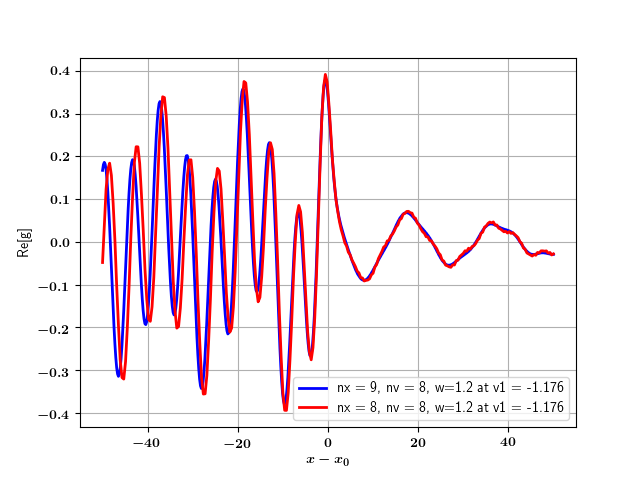

[166. 166.]


<IPython.core.display.Javascript object>


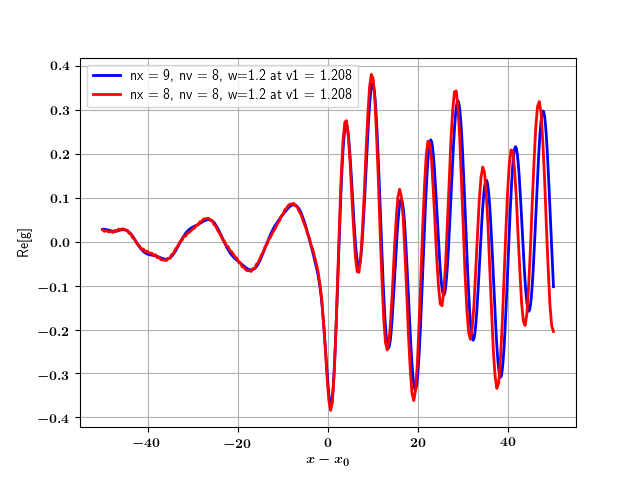

In [15]:
# ---------------------------------------------------
# --- Compare distribution function ---
# ---------------------------------------------------
v1 = -1.18
# v1 = 0.774

fig_gre_vp, fig_gim_vp = compare_g_v1([dd_1, dd_2], v1)
fig_gre_vp, fig_gim_vp = compare_g_v1([dd_1, dd_2], -v1)

del v1

<IPython.core.display.Javascript object>


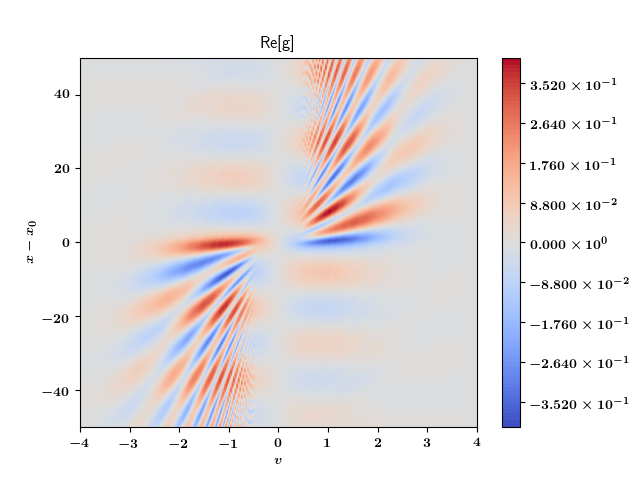

<IPython.core.display.Javascript object>


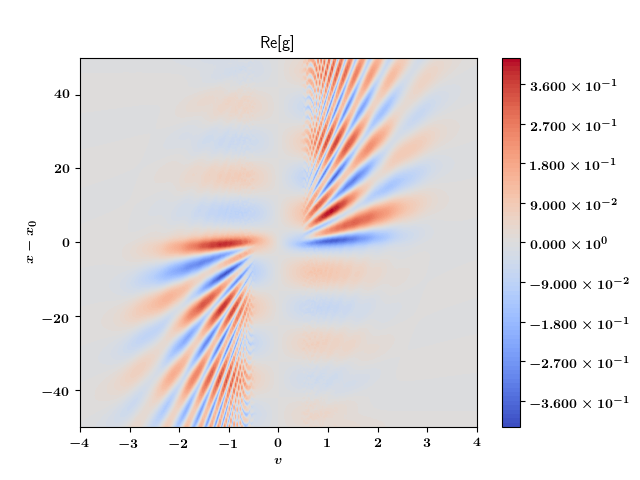

In [16]:
# ---------------------------------------------------
# --- one sim.: g[x,v], E(x) ---
# ---------------------------------------------------
fig_gxv_re, fig_gxv_im = plot_results_one(dd_1)
fig_gxv_re, fig_gxv_im = plot_results_one(dd_2)

In [37]:
# --------------------------------------------------------------
# --- Save data ---
# --------------------------------------------------------------
path_res = "/media/work/docs/codes/QuCF/results/KIN1D1D-results/figs/"
def save_data(dd, label_end):
    mix.save_dat_plot_1d_file(
        path_res + "/num_Ere_w{:0.2f}".format(dd['w'])+label_end+".dat",    
        dd['x'] - dd['x0'], 
        np.real(dd['E'])
    )
    mix.save_dat_plot_1d_file(
        path_res + "/num_Eim_w{:0.2f}".format(dd['w'])+label_end+".dat",    
        dd['x'] - dd['x0'],  
        np.imag(dd['E'])
    )
    return

save_data(dd_2,"_nx7nv5")

del path_res

write data to a file: /media/work/docs/codes/QuCF/results/KIN1D1D-results/figs//num_Ere_w1.20_nx7nv5.dat
write data to a file: /media/work/docs/codes/QuCF/results/KIN1D1D-results/figs//num_Eim_w1.20_nx7nv5.dat


In [ ]:
# ---------------------------------------------------
# --- Save plots---
# ---------------------------------------------------
# fig_gxv_1.savefig('/media/work/docs/codes/QuCF/results/LKW-1D-results/report-04-20-2023/' + "/gxv-w04.png")
# fig_gxv_2.savefig('/media/work/docs/codes/QuCF/results/LKW-1D-results/report-04-20-2023/' + "/gxv-w4.png")

# fig_nv_re.savefig('/media/work/docs/codes/QuCF/results/LKW-1D-results/report-04-20-2023/' + "/Er.png")
# fig_nv_im.savefig('/media/work/docs/codes/QuCF/results/LKW-1D-results/report-04-20-2023/' + "/Ei.png")

# fig_gre_vp.savefig('/media/work/docs/codes/QuCF/results/LKW-1D-results/report-04-20-2023/' + "/gx_re_vp.png")
# fig_gim_vp.savefig('/media/work/docs/codes/QuCF/results/LKW-1D-results/report-04-20-2023/' + "/gx_im_vp.png")
# fig_gre_vn.savefig('/media/work/docs/codes/QuCF/results/LKW-1D-results/report-04-20-2023/' + "/gx_re_vn.png")
# fig_gim_vn.savefig('/media/work/docs/codes/QuCF/results/LKW-1D-results/report-04-20-2023/' + "/gx_im_vn.png")